## 数据加载
#### 数据加载可通过自定义的数据集对象实现。数据集对象被抽象为Dataset类，需要继承。

In [1]:
'''
__getitem__: 返回一条数据或一个样本。
__len__: 返回样本的数量。
'''

'\n__getitem__: 返回一条数据或一个样本。\n__len__: 返回样本的数量。\n'

In [2]:
%env LS_COLORS=None
!tree --charset ascii DogsCats/model1/

env: LS_COLORS=None
DogsCats/model1/
|-- cat.6768.jpg
|-- cat.6769.jpg
|-- cat.6770.jpg
|-- cat.6771.jpg
|-- dog.7944.jpg
|-- dog.7945.jpg
|-- dog.7946.jpg
`-- dog.7947.jpg

0 directories, 8 files


In [3]:
import torch as t
from torch.utils import data

In [4]:
import os
import numpy as np
from PIL import Image

class DogCat(data.Dataset):
    def __init__(self, root):
        imgs = os.listdir(root)
        #所有图片的绝对路径
        #这里不实际加载图片，只是指定路径
        #当调用__getitem__时，才会真正读取图片
        self.imgs = [os.path.join(root, img) for img in imgs]
        
    def __getitem__(self, index):
        img_path = self.imgs[index]
        #dog->1, cat->0
        lable = 1 if 'dog' in img_path.split('/')[-1] else 0
        pil_img = Image.open(img_path)
        array = np.asarray(pil_img)
        data = t.from_numpy(array)
        return data, lable
    
    def __len__(self):
        return len(self.imgs)  

In [5]:
dataset = DogCat('./DogsCats/model1/')
img, label = dataset[0]    #相当于调用dataset.__getitem__(0)
for img, label in dataset:
    print(img.size(), img.float().mean(), label)
    #返回样本的形状不一，每张图片的大小不一样，这对于需要去batch训练的神经网络来说不友好
    #返回样本的数值较大，为归一化至[-1, 1]

torch.Size([379, 440, 3]) tensor(83.9304) 0
torch.Size([272, 359, 3]) tensor(50.3749) 0
torch.Size([499, 490, 3]) tensor(114.9492) 1
torch.Size([363, 378, 3]) tensor(96.6454) 1
torch.Size([426, 500, 3]) tensor(96.8339) 1
torch.Size([429, 452, 3]) tensor(66.6207) 0
torch.Size([497, 499, 3]) tensor(119.7982) 0
torch.Size([499, 423, 3]) tensor(142.7898) 1


In [6]:
#利用torchvision对图像进行处理
import os
from PIL import Image
import numpy as np
from torchvision import transforms 

transform = transforms.Compose([transforms.Resize(224),    #缩放图片（Image），保持长宽比不变，最短边为224像素
                                transforms.CenterCrop(224),    #从图片中间切出224*224
                                transforms.ToTensor(),    #将图片转成Tensor，归一化至[0, 1]
                                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  #将标准化至[-1, 1]
                               ])

class DogCat(data.Dataset):
    def __init__(self, root, transforms=None):
        imgs = os.listdir(root)
        self.imgs = [os.path.join(root, img) for img in imgs]
        self.transforms = transform
        
    def __getitem__(self, index):
        img_path = self.imgs[index]
        #dog->0, cat->1
        label = 0 if 'dog' in img_path.split('/')[-1] else 1
        data = Image.open(img_path)
        if self.transforms:
            data = self.transforms(data)
        return data, label
    
    def __len__(self):
        return len(self.imgs)  

In [7]:
dataset = DogCat('./DogsCats/model1/', transforms=transform)
img, label = dataset[0]
for img, label in dataset:
    print(img.size(), label)

torch.Size([3, 224, 224]) 1
torch.Size([3, 224, 224]) 1
torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 1
torch.Size([3, 224, 224]) 1
torch.Size([3, 224, 224]) 0


In [8]:
!tree --charset ASCII ./DogsCats/model2/

./DogsCats/model2/
|-- Cat
|   |-- cat.6768.jpg
|   |-- cat.6769.jpg
|   |-- cat.6770.jpg
|   `-- cat.6771.jpg
`-- Dog
    |-- dog.7944.jpg
    |-- dog.7945.jpg
    |-- dog.7946.jpg
    `-- dog.7947.jpg

2 directories, 8 files


In [9]:
from torchvision.datasets import ImageFolder
dataset = ImageFolder('./DogsCats/model2/')

In [10]:
#cat文件夹的图片对应label0，dog对应1
dataset.class_to_idx

{'Cat': 0, 'Dog': 1}

In [11]:
dataset.imgs

[('./DogsCats/model2/Cat/cat.6768.jpg', 0),
 ('./DogsCats/model2/Cat/cat.6769.jpg', 0),
 ('./DogsCats/model2/Cat/cat.6770.jpg', 0),
 ('./DogsCats/model2/Cat/cat.6771.jpg', 0),
 ('./DogsCats/model2/Dog/dog.7944.jpg', 1),
 ('./DogsCats/model2/Dog/dog.7945.jpg', 1),
 ('./DogsCats/model2/Dog/dog.7946.jpg', 1),
 ('./DogsCats/model2/Dog/dog.7947.jpg', 1)]

0


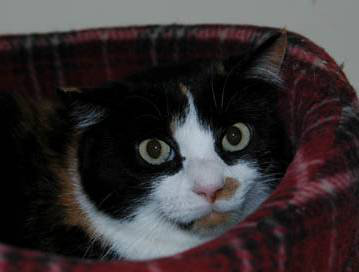

In [12]:
#没有任何的transform，所以返回的还是PIL Image对象
#第一维是第几张图，第二维是返回label
print(dataset[0][1])
dataset[0][0]

In [14]:
#加上transform
normalize = transforms.Normalize(mean=[0.4, 0.4, 0.4], std=[0.2, 0.2, 0.2])
transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                normalize
                               ])

In [15]:
dataset = ImageFolder('./DogsCats/model2/', transform=transform)

In [16]:
dataset[0][0].size()

torch.Size([3, 224, 224])

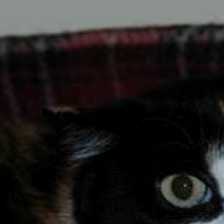

In [17]:
to_img = transforms.ToPILImage()
to_img(dataset[0][0]*0.2+0.4)

In [18]:
from torch.utils.data import DataLoader

In [19]:
dataloader = DataLoader(dataset, batch_size=3, shuffle=True, num_workers=0, drop_last=False)

In [42]:
dataiter = iter(dataloader)
imgs, labels = next(dataiter)
imgs.size()    #batch_size, channel, height, weight

torch.Size([3, 3, 224, 224])

## 视觉工具包 torchvision

In [44]:
from torchvision import models
from torch import nn
# 加载预训练好的模型，如果不存在会下载在 ～/.torch/models/下面
resnet34 = models.resnet34(pretrained=True, num_classes=1000)
#修改最后的全连接层为10分类
resnet34.fc = nn.Linear(512, 10)

In [45]:
from torchvision import datasets
dataset = datasets.MNIST('./MNIST', download=True, train=False, transform=transform)

Processing...
Done!


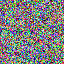

In [61]:
from torchvision import transforms
to_pil = transforms.ToPILImage()
to_pil(t.randn(3, 64, 64))

In [62]:
len(dataset)

10000

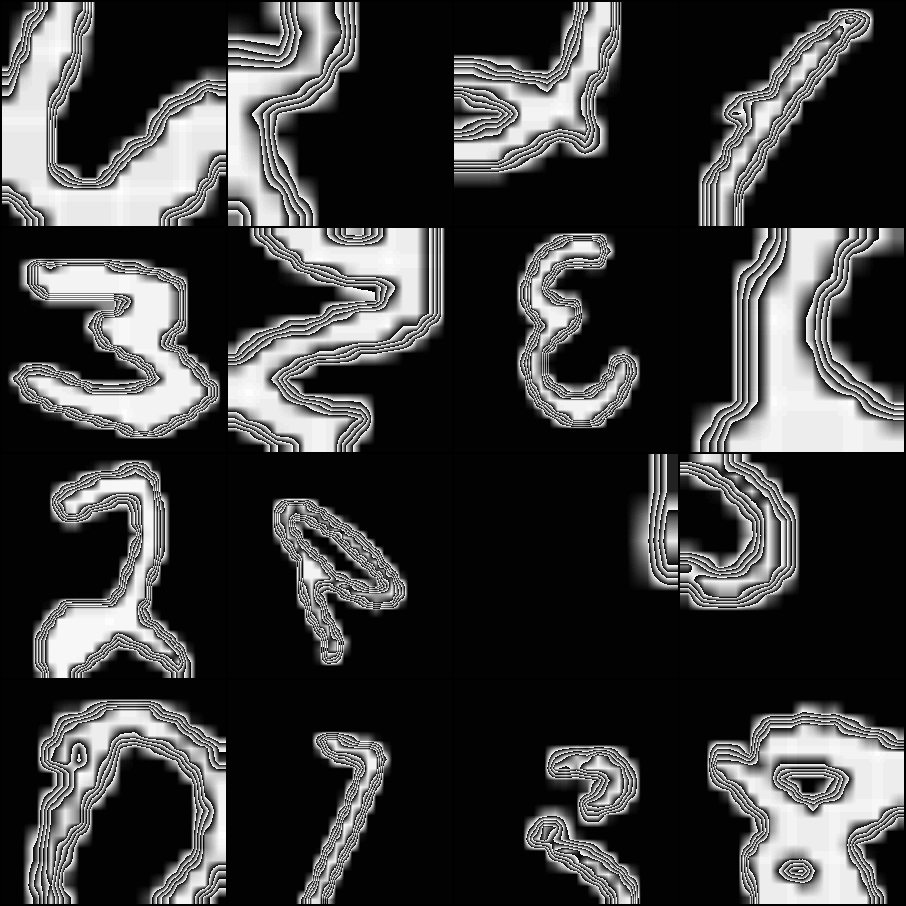

In [68]:
dataloader = DataLoader(dataset, shuffle=True, batch_size=16)
from torchvision.utils import make_grid, save_image
dataiter = iter(dataloader)
img = make_grid(next(dataiter)[0], 4) #把batch_size =16个，拼为4*4，通道为3
to_img(img)

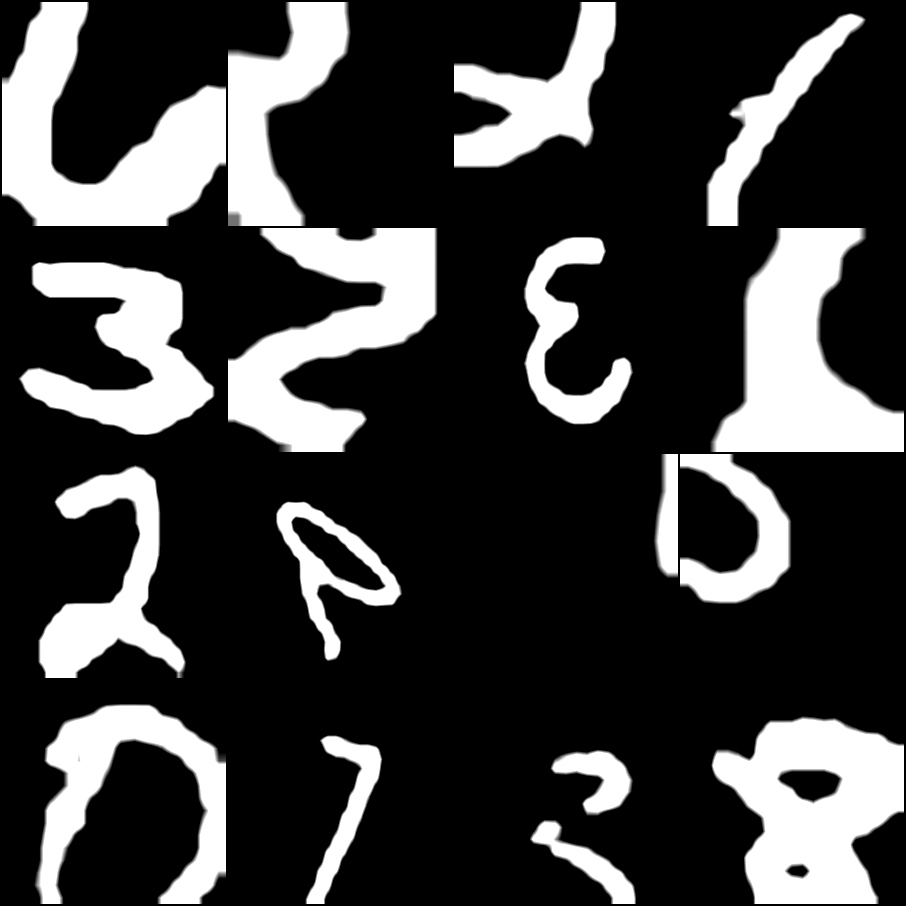

In [70]:
save_image(img, 'a.png')
Image.open('a.png')